              precision    recall  f1-score   support

           0       0.92      0.92      0.92        60
           1       0.92      0.92      0.92        59

    accuracy                           0.92       119
   macro avg       0.92      0.92      0.92       119
weighted avg       0.92      0.92      0.92       119



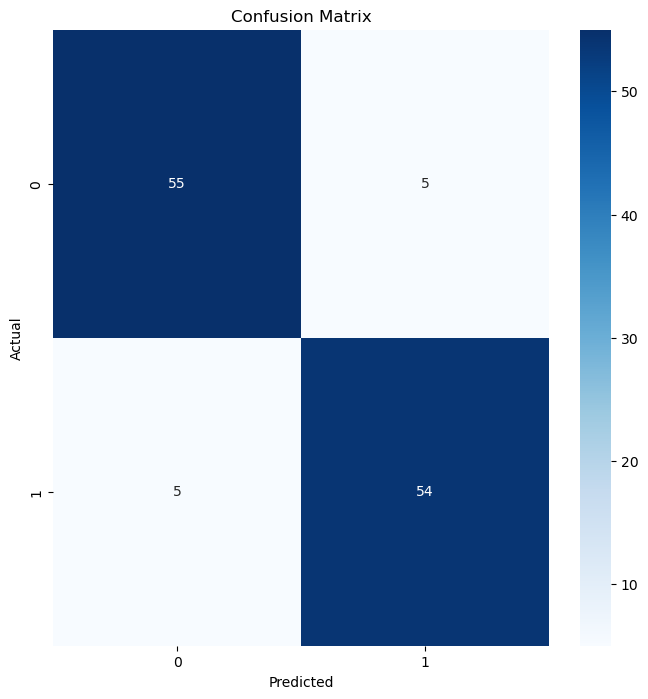

Best Parameters of SVC model are: {'gamma': 0.01, 'C': 0.1}

Cross-validation mean score: 0.6701535087719298
Input: [1, 70, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1], Predicted Lung Cancer Status: Positive


In [3]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("dataset.csv")
df.drop_duplicates(inplace=True)

# Clean column names and encode categorical variables
df.columns = df.columns.str.strip()
encoder = LabelEncoder()
df['LUNG_CANCER'] = encoder.fit_transform(df['LUNG_CANCER'])
df['GENDER'] = encoder.fit_transform(df['GENDER'])

# Prepare features and target
X = df.drop(['LUNG_CANCER'], axis=1)
y = df['LUNG_CANCER']

# Adjust feature columns
X[X.columns[2:]] -= 1  # Adjusting columns directly without loop

# Handle class imbalance using SMOTE
smote = SMOTE()
X_over, y_over = smote.fit_resample(X, y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state=42, stratify=y_over)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using RandomizedSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
rcv = RandomizedSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
rcv.fit(X_train, y_train)

# Predictions and evaluation
y_pred_svc = rcv.predict(X_test)
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix
confusion_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(f'Best Parameters of SVC model are: {rcv.best_params_}\n')

# Cross-validation
scores = cross_val_score(rcv.best_estimator_, X_over, y_over, cv=5)
print(f"Cross-validation mean score: {scores.mean()}")

# Define prediction function
def predict_lung_cancer(data):
    # Create a DataFrame with appropriate column names
    column_names = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 
                    'ANXIETY', 'PEER_PRESSURE', 'CHRONIC DISEASE', 
                    'FATIGUE', 'ALLERGY', 'WHEEZING', 
                    'ALCOHOL CONSUMING', 'COUGHING', 
                    'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 
                    'CHEST PAIN']
    
    input_df = pd.DataFrame([data], columns=column_names)  # Create DataFrame
    
    # Scale the input features
    scaled_data = scaler.transform(input_df)  # Scale the input data
    
    # Predict using the trained model
    prediction = rcv.predict(scaled_data)
    
    # Map prediction to readable output
    return "Positive" if prediction[0] == 1 else "Negative"

# Test with new inputs
test_inputs = [ [1, 70, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1]]

for new_values in test_inputs:
    prediction = predict_lung_cancer(new_values)
    print(f"Input: {new_values}, Predicted Lung Cancer Status: {prediction}")

# Summary statistics of the dataset
#summary_stats = df.describe(include='all')
#print("\nSummary Statistics of the Dataset:")
#print(summary_stats)

# Class distribution
#class_distribution = df['LUNG_CANCER'].value_counts(normalize=True) * 100
#print("\nClass Distribution (%):")
#print(class_distribution)
# Save the trained model
with open('svc_model.pkl', 'wb') as model_file:
    pickle.dump(rcv.best_estimator_, model_file)

# Save the scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)